# Estatística para Ciência de Dados - Avaliação Final

Profa. Mariana Cúri<br>
Universidade de São Paulo, São Carlos, Brasil.<br>
Aluno: Rômulo Róseo Rebouças

### Estudo dos dados do arquivo Brain que referem-se ao peso do cérebro (g), tamanho da cabeça (cm3) de 237 adultos,  identificados por sexo e grupo etário. O estudo teve por objetivo verificar se:<br>
    1) Há diferença no peso cerebral entre os sexos? E entre os grupos etários?
    2) O tamanho da cabeça é preditor do peso cerebral e, neste caso, há diferença nessa relação entre os sexos e entre os grupos etários? 
    3) Estime o peso médio do cérebro de homens e de mulheres (pontual e intervalar).

### O trabalho é composto das seguintes fases:<br>
  
#### Análise dos dados <br>
* Verificação de atributos faltantes,<br>
* Verificação da necessidade de normalização ou padronização.<br>
* Verificação da necessidade de transformação para valores numéricos (one-hot-encoding) se precisar.<br>
#### Modelagem:<br>
* Testar se há diferença entre o peso cerebral e os sexos, e entre os grupos etários.<br>
* Elaborar modelo de regressão para verificar se o tamanho da cabeça é preditor do peso cerebral e, neste caso, se há diferença nessa relação entre os sexos e entre os grupos etários<br>
* Estimar o peso médio do cérebro de homens e de mulheres<br>
#### Conclusão:<br>
* A interpretação, resultados resumidos e comentários estão disponíveis no arquivo .pdf anexo.

### Análise dos dados

In [1]:
##-- Importação dos pacotes
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
##-- Leitura do aquivo 
df = pd.read_csv("E:/_USP-CEMAI/Dados/Estatisitica_Ciencia_Dados/Brain.csv", encoding= 'unicode_escape')
df.columns = ['Sexo', 'Gr_Acima45', 'Tam_Cabeca', 'Peso_Cerebral']
##-- Para o sexo, fica estabelecido que: 0 - feminino e 1 - masculino
##-- Para o Grupo Etário, fica estabelecidoque: 0 - Abaixo de 45 anos; 1 - Acima de 45 anos

print (df.shape[0])
df.head()

237


,Sexo,Gr_Acima45,Tam_Cabeca,Peso_Cerebral
0,1,0,4512,1530
1,1,0,3738,1297
2,1,0,4261,1335
3,1,0,3777,1282
4,1,0,4177,1590


In [3]:
df.describe()

,Sexo,Gr_Acima45,Tam_Cabeca,Peso_Cerebral
count,237.000000,237.000000,237.000000,237.000000
mean,0.565401,0.535865,3633.991561,1282.873418
std,0.496753,0.499768,365.261422,120.340446
min,0.000000,0.000000,2720.000000,955.000000
25%,0.000000,0.000000,3389.000000,1207.000000
50%,1.000000,1.000000,3614.000000,1280.000000
75%,1.000000,1.000000,3876.000000,1350.000000
max,1.000000,1.000000,4747.000000,1635.000000


In [4]:
#-- Verifica se possui dados duplicados
data_nred = df.drop_duplicates(keep='first')
data_nred.describe()

,Sexo,Gr_Acima45,Tam_Cabeca,Peso_Cerebral
count,237.000000,237.000000,237.000000,237.000000
mean,0.565401,0.535865,3633.991561,1282.873418
std,0.496753,0.499768,365.261422,120.340446
min,0.000000,0.000000,2720.000000,955.000000
25%,0.000000,0.000000,3389.000000,1207.000000
50%,1.000000,1.000000,3614.000000,1280.000000
75%,1.000000,1.000000,3876.000000,1350.000000
max,1.000000,1.000000,4747.000000,1635.000000


In [5]:
##-->> Não possui dados duplicados

In [6]:
#-- Verifica os tipos dos atributos
df.dtypes

Sexo             int64
Gr_Acima45       int64
Tam_Cabeca       int64
Peso_Cerebral    int64
dtype: object

In [7]:
#-- Verifica outliers

def remove_nans_outliers(df, attributes, out_in=0):
    
    dfn = df.copy()
    
    for var in attributes:
        # verifica se variável é numerica
        if np.issubdtype(df[var].dtype, np.number):
            Q1 = df[var].quantile(0.25)
            Q2 = df[var].quantile(0.25)
            Q3 = df[var].quantile(0.75)
            IQR = Q3 - Q1
        
        if out_in==0 :
            # apenas inliers segundo IQR
            dfn = df.loc[(df[var] >= Q1-(IQR*1.5)) & (df[var] <= Q3+(IQR*1.5)), :]
        else:
            # apenas outliers segundo IQR
            dfn = df.loc[(df[var] < Q1-(IQR*1.5)) | (df[var] > Q3+(IQR*1.5)), :]
            
        dfn = dfn.loc[dfn[var].notnull(),:]
        
    return dfn

attributes = ['Tam_Cabeca', 'Peso_Cerebral']

data = remove_nans_outliers(data_nred, attributes, 0)
data_out = remove_nans_outliers(data_nred, attributes, 1)

print("Antes: %d, Depois remocao outliers: %d" % (data_nred.shape[0], data.shape[0]))

Antes: 237, Depois remocao outliers: 231


In [8]:
##-- Lista Outliers -- Valores consideraos extremos 
data_out

,Sexo,Gr_Acima45,Tam_Cabeca,Peso_Cerebral
4,1,0,4177,1590
24,1,0,4747,1635
43,1,0,3804,1570
102,1,1,3876,1588
109,1,1,4430,1620
209,0,1,2720,955


#### >> Para a variável Tam_Cabeca o valor [4.747] foi considera outiler
#### >> Para a variável Peso_Cerebral os valores [1590,1635,1570,1588,1620,955] foram considerados outilers

In [9]:
##-- Dados sem outliers
data.describe()

,Sexo,Gr_Acima45,Tam_Cabeca,Peso_Cerebral
count,231.000000,231.000000,231.000000,231.000000
mean,0.558442,0.536797,3625.549784,1277.415584
std,0.497651,0.499727,351.268293,110.252873
min,0.000000,0.000000,2773.000000,1012.000000
25%,0.000000,0.000000,3386.000000,1206.000000
50%,1.000000,1.000000,3609.000000,1280.000000
75%,1.000000,1.000000,3860.500000,1350.000000
max,1.000000,1.000000,4512.000000,1560.000000


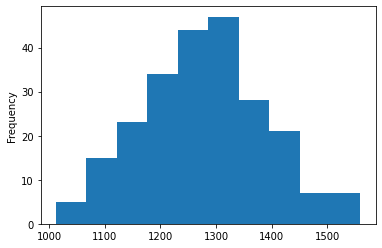

In [10]:
data['Peso_Cerebral'].plot.hist()

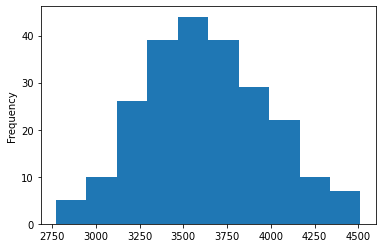

In [11]:
data['Tam_Cabeca'].plot.hist()

Perc Sexo Masculino: 55.84 
Perc Grupo Etário Acima de 45 anos: 53.68 


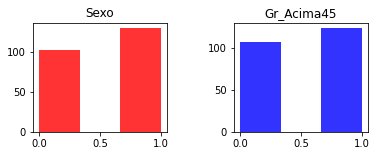

In [12]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax1 = fig.add_subplot(2, 2, 1)
ax1.hist(data['Sexo'], bins=3, color='r', alpha=0.8)
ax1.set(title= 'Sexo')
ax2 = fig.add_subplot(2, 2, 2)
ax2.hist(data['Gr_Acima45'], bins=3, color='b', alpha=0.8)
ax2.set(title= 'Gr_Acima45')
plt.subplots_adjust(wspace=0.5, hspace=0)
print('Perc Sexo Masculino: %.2f ' % ((data['Sexo'].sum()/data['Sexo'].shape[0])*100))
print('Perc Grupo Etário Acima de 45 anos: %.2f ' % ((data['Gr_Acima45'].sum()/data['Gr_Acima45'].shape[0])*100))

#### >> As variáveis categóricas apresentam-se bem balanceadas.

### Modelagem
### 1) Há diferença no peso cerebral entre os sexos? E entre os grupos etários?
### - Peso cerebral versus sexo

In [13]:
##-- Peso cerebral por sexo
data.groupby('Sexo')['Peso_Cerebral'].describe()

,count,mean,std,min,25%,50%,75%,max
Sexo,,,,,,,,
0,102.0,1221.735294,100.944542,1012.0,1152.5,1220.0,1290.0,1520.0
1,129.0,1321.441860,96.839421,1120.0,1250.0,1310.0,1390.0,1560.0


In [14]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

# Generate some data for this demonstration. 
data1 = data.loc[data['Sexo']==0, 'Peso_Cerebral'] # dados do tipo Feminino
data2 = data.loc[data['Sexo']==1, 'Peso_Cerebral'] # dados do tipo Masculino

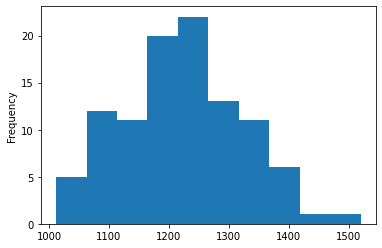

In [15]:
data1.plot.hist() #-- Peso Cerebral sexo feminino

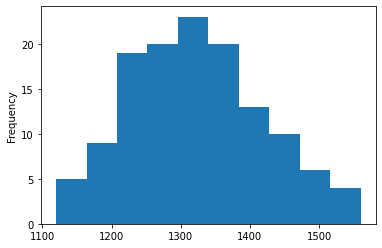

In [16]:
data2.plot.hist() #-- Peso Cerebral sexo masculino

In [17]:
# Teste de Levene para igualdade de variâncias
stats.levene(data1,data2)

# Considerando alpha=0.05 a Hipótese Nula H0 (igualdade de variâncias) não pode ser rejeitada, 
# pois o valor p é maior que alpha

LeveneResult(statistic=0.20012496119093054, pvalue=0.6550428472167493)

#### >> As variâncias do Peso Cerebral entre os Sexos podem ser consideradas iguais

In [18]:
# Teste t de Student (bicaudal) para média de duas populações Normais com variâncias iguais
stats.ttest_ind(data1,data2, equal_var = True)

Ttest_indResult(statistic=-7.626460860129644, pvalue=6.406844045347685e-13)

#### >> As médias do Peso Cerebral entre os Sexos podem ser consideradas diferentes, a um nível de significancia de alfa = 5%

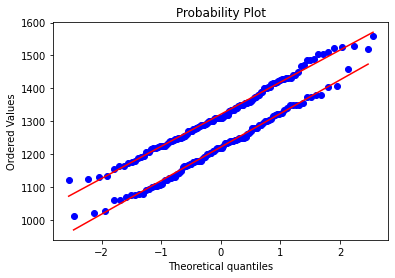

<Figure size 432x288 with 0 Axes>

In [19]:
# Gráfico de probabilidade da Normal, para checar suposição de tal distribuição dos dados
# para o teste t de Student
stats.probplot(data1, plot=plt)
stats.probplot(data2, plot=plt)
fig = plt.figure()

In [20]:
# Teste da diferença de duas amostras independentes
# teste não paramétrico Mann–Whitney U
# A hipótese nula é de que as distribuições são iguais.
stats.mannwhitneyu(data1,data2)

MannwhitneyuResult(statistic=3161.0, pvalue=6.1610130807503855e-12)

#### >> As distribuições amostrais do Peso Cerebral entre os Sexos podem ser consideradas diferentes.

### - Peso cerebral versus grupos etários

In [21]:
##-- Peso cerebral por Grupo Etário
data.groupby('Gr_Acima45')['Peso_Cerebral'].describe()

,count,mean,std,min,25%,50%,75%,max
Gr_Acima45,,,,,,,,
0,107.0,1296.504673,106.798379,1027.0,1224.5,1300.0,1357.5,1530.0
1,124.0,1260.943548,110.951194,1012.0,1180.0,1250.0,1330.0,1560.0


In [22]:
# Generate some data for this demonstration. 
data1 = data.loc[data['Gr_Acima45']==0, 'Peso_Cerebral'] # Grupo abaixo de 45 anos
data2 = data.loc[data['Gr_Acima45']==1, 'Peso_Cerebral'] # Grupo acima de 45 anos

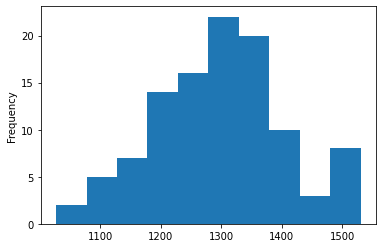

In [23]:
data1.plot.hist() #-- Peso Cerebral grupo etário menor que 45 anos

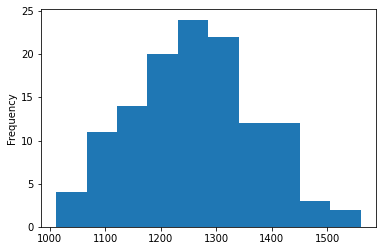

In [24]:
data2.plot.hist() #-- Peso Cerebral grupo etário maior que 45 anos

In [25]:
# Teste de Levene para igualdade de variâncias
stats.levene(data1,data2)

# Considerando alpha=0.05 a Hipótese Nula H0 (igualdade de variâncias) não pode ser rejeitada, 
# pois o valor p é maior que alpha

LeveneResult(statistic=0.19799765601375685, pvalue=0.6567622537785363)

#### >> As variâncias do Peso Cerebral entre os Grupos Etários podem ser consideradas iguais

In [26]:
# Teste t de Student (bicaudal) para média de duas populações Normais com variâncias iguais
stats.ttest_ind(data1,data2, equal_var = True)

Ttest_indResult(statistic=2.4714519115779985, pvalue=0.014185449403348203)

#### >> As médias do Peso Cerebral entre os Grupos Etários podem ser consideradas diferentes, a um nível de significancia de alfa = 5%.

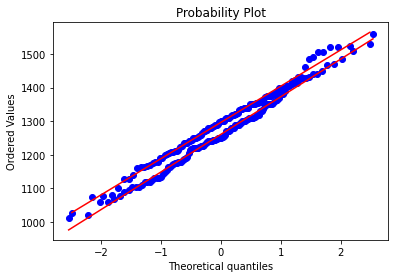

<Figure size 432x288 with 0 Axes>

In [27]:
# Gráfico de probabilidade da Normal, para checar suposição de tal distribuição dos dados
# do ENEM, para o teste t de Student
stats.probplot(data1, plot=plt)
stats.probplot(data2, plot=plt)
fig = plt.figure()

In [28]:
# Teste da diferença de duas amostras independentes
# teste não paramétrico Mann–Whitney U
# A hipótese nula é de que as distribuições são iguais.
stats.mannwhitneyu(data1,data2)

MannwhitneyuResult(statistic=5383.5, pvalue=0.006788491423183411)

#### >> As distribuições amostrais do Peso Cerebral por Grupo Etário podem ser consideradas diferentes.

### 2) O tamanho da cabeça é preditor do peso cerebral e, neste caso, há diferença nessa relação entre os sexos e entre os grupos etários? 

In [29]:
data_reg = data.copy()
data_reg[['Peso_Cerebral','Tam_Cabeca']].describe()

,Peso_Cerebral,Tam_Cabeca
count,231.000000,231.000000
mean,1277.415584,3625.549784
std,110.252873,351.268293
min,1012.000000,2773.000000
25%,1206.000000,3386.000000
50%,1280.000000,3609.000000
75%,1350.000000,3860.500000
max,1560.000000,4512.000000


C:\Users\romul\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\romul\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\romul\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\romul\Anaconda3\lib\site-packages\pandas\plotting\_matpl

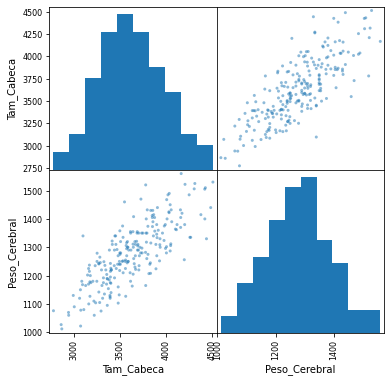

In [30]:
from pandas.plotting import scatter_matrix

data_plot = data_reg[['Tam_Cabeca', 'Peso_Cerebral']]

# Constrói os gráficos de dispersão em pares
scatter_matrix(data_plot, alpha = 0.5, figsize = (6, 6))
plt.show()

In [31]:
#Calcula o coeficiente de correlação de Pearson
cor,pvalor = stats.pearsonr(data_reg['Peso_Cerebral'],data_reg['Tam_Cabeca'])
print('Coeficiente de correlação:' ,cor)
print('p-valor (H0: correlação igual a 0):' ,pvalor)

Coeficiente de correlação: 0.7897099172761768
p-valor (H0: correlação igual a 0): 1.6955778788144382e-50


#### >> Existe boa correlação entre o Peso Cerebral e o Tamanho da Cabeça. Aproximadamente 80%. Apresentam ainda mesma tendência positiva de crescimento.

### Regressão Linear

In [32]:
## Regressão Linear --
## Foi considerada a transformação da variável Tam_Cabeca centalizada pela sua Média
## Foi utilizado o método backward com as variáveis para realizar o ajuste do modelo
from statsmodels.formula.api import ols

#-- 1. tentativa - todas as variáveis
data_reg['Tam_Cabeca_c'] = data_reg['Tam_Cabeca'] - np.mean(data_reg['Tam_Cabeca'])
mod = ols('Peso_Cerebral ~ Tam_Cabeca_c + Sexo + Gr_Acima45 + Tam_Cabeca_c*Sexo + Tam_Cabeca_c*Gr_Acima45',data=data_reg)
res = mod.fit()
print(res.summary())

##--Calculo do VIF (fator de inflação de variação)
#-- Gerar uma matriz de experimento adequada para a regressão.
y, X = dmatrices('Peso_Cerebral ~ Tam_Cabeca_c + Sexo + Gr_Acima45 + Tam_Cabeca_c*Sexo + Tam_Cabeca_c*Gr_Acima45',data=data_reg, return_type='dataframe')

# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif)

                            OLS Regression Results                            
Dep. Variable:          Peso_Cerebral   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.636
Method:                 Least Squares   F-statistic:                     81.37
Date:                Wed, 17 Jun 2020   Prob (F-statistic):           1.70e-48
Time:                        08:58:59   Log-Likelihood:                -1294.4
No. Observations:                 231   AIC:                             2601.
Df Residuals:                     225   BIC:                             2621.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                1

In [33]:
#-- 2. tentativa - exclusão da interação Tam_Cabeca_c x Gr_Acima45 por possuir o maior p-value 
mod = ols('Peso_Cerebral ~ Tam_Cabeca_c + Sexo + Gr_Acima45 + Tam_Cabeca_c*Sexo ',data=data_reg)
res = mod.fit()
print(res.summary())

##--Calculo do VIF (fator de inflação de variação)
#-- Gerar uma matriz de experimento adequada para a regressão.
y, X = dmatrices('Peso_Cerebral ~ Tam_Cabeca_c + Sexo + Gr_Acima45 + Tam_Cabeca_c*Sexo ',data=data_reg, return_type='dataframe')

# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif)

                            OLS Regression Results                            
Dep. Variable:          Peso_Cerebral   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.636
Method:                 Least Squares   F-statistic:                     101.4
Date:                Wed, 17 Jun 2020   Prob (F-statistic):           2.68e-49
Time:                        08:59:00   Log-Likelihood:                -1294.9
No. Observations:                 231   AIC:                             2600.
Df Residuals:                     226   BIC:                             2617.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          1284.3879      8.86

In [34]:
#-- 3. tentativa - exclusão da interação Tam_Cabeca_c x Sexo (com p-value alto) e mautenção da variável Sexo
#   (também com p-value alto) para análise. 
mod = ols('Peso_Cerebral ~ Tam_Cabeca_c + Sexo + Gr_Acima45 ',data=data_reg)
res = mod.fit()
print(res.summary())

##--Calculo do VIF (fator de inflação de variação)
#-- Gerar uma matriz de experimento adequada para a regressão.
y, X = dmatrices('Peso_Cerebral ~ Tam_Cabeca_c + Sexo + Gr_Acima45 ',data=data_reg, return_type='dataframe')

# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif)

                            OLS Regression Results                            
Dep. Variable:          Peso_Cerebral   R-squared:                       0.638
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     133.3
Date:                Wed, 17 Jun 2020   Prob (F-statistic):           8.28e-50
Time:                        08:59:00   Log-Likelihood:                -1296.3
No. Observations:                 231   AIC:                             2601.
Df Residuals:                     227   BIC:                             2614.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     1278.5555      8.169    156.511   

> Existe o indicativo de possível falta de significância do parâmetro para a variável Sexo, pois o seu p-value está pouco acima de 5%. Dissidiou-se então, realizar o teste conjunto das variáveis categóricas Sexo e Gr_Acima45 com a finalidade de optar em manter ou não a variável Sexo no modelo.

In [35]:
##-- Teste connjunto para verificação dos parâmetros do modelo
#-   H0: Sexo = Gr_Acima45 = 0 (são os dois últimos parâmetros de regressão do modelo)
R = [[0, 0, 0, 1], [0, 0, 1, 0]]
print(np.array(R))
print(res.f_test(R))

[[0 0 0 1]
 [0 0 1 0]]
<F test: F=array([[4.45466277]]), p=0.012657995052912336, df_denom=227, df_num=2>


> No teste conjunto dos parâmetros de Sexo e Gr_Acima45 verificou-se que são diferentes de 0, existe significância e o p-value está abaixo de 5%. Optou-se então, em manter a variável Sexo no modelo.

> Isto sugere que todos os parâmetros de regressão são significativamente diferentes de zero. Observa-se que o $R^2$ ajustado (63%), o AIC e o BIC, se mantêm com pouca variação se comparados aos  modelos anteriores.  

> O novo modelo demonstra não ter indicativo de multicolinearidade, com VIF's (Fator de Inflação da Variância) considerados baixos.

> Observa-se ainda, que o coeficiente de Durbin-Watson foi aproximadamente 2 (1,99) indicando que os resíduos não são autocorrelacionados.

> Desta forma o modelo escolhido para dar continuidade nos trabalhos foi o da '3. tentativa' com as variáveis preditoras: Tam_Cabeca_c, Sexo e Gr_Acima45.

### Análise do resíduo

In [36]:
# valores preditos de E(Y)
ypred=res.fittedvalues

# resíduo=observado-ajustado
residuo = res.resid

# objeto para a análise de pontos influentes
infl = res.get_influence()

# diagonal da matriz hat
hii = infl.hat_matrix_diag

# resíduo studentizado (internamente)
res_stud = infl.resid_studentized_internal

# resíduo studentizado com i-ésima observação deletada (externamente)
res_stud_del = infl.resid_studentized_external

# DFFITS
(dffits,p) = infl.dffits

# Distância de Cook
(cook,p) = infl.cooks_distance

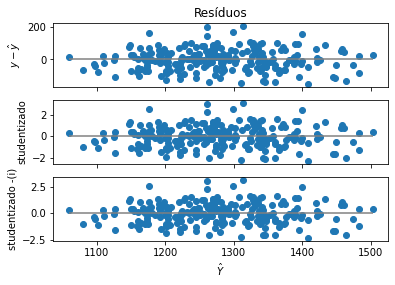

In [37]:
##-- Elabora os gráficos de todos os resíduos
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.scatter(ypred, residuo)
ax1.set_ylabel('$y-\hat{y}$')
ax1.set_title('Resíduos')
ax1.hlines(0,xmin=min(ypred),xmax=max(ypred),color='gray')
ax2.scatter(ypred, res_stud)
ax2.set_ylabel('studentizado')
ax2.hlines(0,xmin=min(ypred),xmax=max(ypred),color='gray')
ax3.scatter(ypred, res_stud_del)
ax3.set_ylabel('studentizado -(i)')
ax3.hlines(0,xmin=min(ypred),xmax=max(ypred),color='gray')
ax3.set_xlabel('$\hat{Y}$')

for ax in fig.get_axes():
    ax.label_outer()

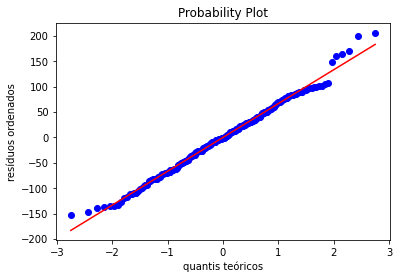

In [38]:
# Verificando a suposição de distribuição Normal dos resíduos
stats.probplot(residuo, plot=plt)
plt.xlabel('quantis teóricos')
plt.ylabel('resíduos ordenados')
plt.show()

> Observa-se que os resíduos se concentram em torno do eixo (zero) apresentando boa distribuição. O gráfico com resultados studentizados não possuem resíduos acima de 3 (em modulo), assim não têm indicativo de possuir outliers.

> O gráfico dos resíduos versus a função dos quantis teóricos da distribuição normal nos mostra que aparentemente não existe problemas quanto a suposição de normalidade..

> Destaca-se que a retirada de outliers no tratamento dos dados (início do trabalho) pode ter minimizado este efeito.

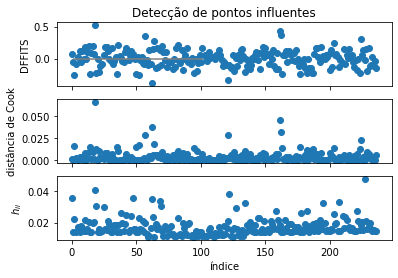

In [39]:
##-- Pontos Influentes
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.scatter(data_reg.index, dffits)
ax1.set_ylabel('DFFITS')
ax1.set_title('Detecção de pontos influentes')
ax1.hlines(0,xmin=1,xmax=102,color='gray')
ax2.scatter(data_reg.index, cook)
ax2.set_ylabel('distância de Cook')
ax3.scatter(data_reg.index, hii)
ax3.set_ylabel('$h_{ii}$')
ax3.set_xlabel('índice')

for ax in fig.get_axes():
    ax.label_outer()

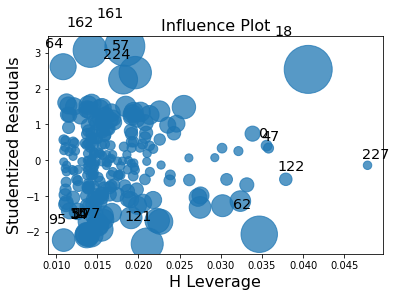

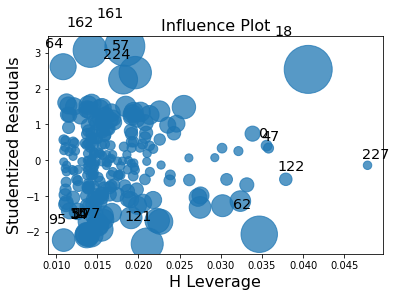

In [40]:
import statsmodels.api as sm

# Gráficos dos resíduos
sm.graphics.influence_plot(res)

In [41]:
##-- Identificação de Hii´s acima do tolerado
p = sum(hii)
n = len(hii)
hii_param = 2*p/n
print('Parâmetro limite de Hii: ', hii_param )
for i in hii:
    if i > hii_param :
        print(i)

Parâmetro limite de Hii:  0.03463203463203444
0.03556948039831126
0.04063087817294376
0.035809355729194636
0.03467694399657335
0.037907518152775835
0.04784086892420898


> Os DFFITS não apresentam casos superior a 1 e nem abaixo de -1, apresentando bom comportamento com relação aos resíduos. A distância de Cook apresenta 1 valor acima de 0,05. No gráfico do Hii aparecem 7 observações acima do parâmetro 0.035, porém apenas 1 mostra-se mais significativa (a de 0,47). O resultado abaixo lista estes valores.

> O gráfico de resíduos studentizados versus H Leverage apresenta 1 valor com maior destaque, o resíduo 227. O caso deve ser verificado em termos de exclusão ou não do estudo. No entanto, deve-se ponderar a sua exclusão, levando-se em conta que foi feito tratamento de eliminação de outliers na preparação dos dados.

### Análise da diferença na relação entre os sexos e entre os grupos etários

In [42]:
data_reg.describe()

,Sexo,Gr_Acima45,Tam_Cabeca,Peso_Cerebral,Tam_Cabeca_c
count,231.000000,231.000000,231.000000,231.000000,2.310000e+02
mean,0.558442,0.536797,3625.549784,1277.415584,-6.378275e-13
std,0.497651,0.499727,351.268293,110.252873,3.512683e+02
min,0.000000,0.000000,2773.000000,1012.000000,-8.525498e+02
25%,0.000000,0.000000,3386.000000,1206.000000,-2.395498e+02
50%,1.000000,1.000000,3609.000000,1280.000000,-1.654978e+01
75%,1.000000,1.000000,3860.500000,1350.000000,2.349502e+02
max,1.000000,1.000000,4512.000000,1560.000000,8.864502e+02


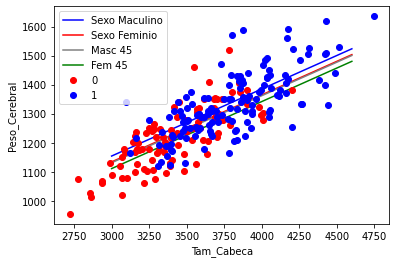

In [43]:
import itertools

##### Entendendo o que é a interação
x = np.linspace(3000,4600) #-- Tamanho da Cabeça
y1 = (1278.5555+20.1117) + 0.2306*(x-3625.5497)  # Sexo Maculino
y2 = (1278.5555) + 0.2306*(x-3625.5497)  # Sexo Feminio
y3 = (1278.5555+20.1117-23.0462) + 0.2306*(x-3625.5497)  # Sexo Maculino e Grupo Etário Maior que 45 anos
y4 = (1278.5555-23.0462) + 0.2306*(x-3625.5497)     # Sexo Feminino e Grupo Etário Maior que 45 anos

plt.plot(x, y1, label="Sexo Maculino", color="blue")
plt.plot(x, y2, label="Sexo Feminio", color="red")
plt.plot(x, y3, label="Masc 45",color="gray")
plt.plot(x, y4, label="Fem 45",color="green")
colors = itertools.cycle(["r", "b", "gray"])
groups = df.groupby("Sexo")
for name, group in groups:
    plt.plot(group["Tam_Cabeca"], group["Peso_Cerebral"], marker="o", linestyle="", label=name, color=next(colors))
plt.legend()
plt.xlabel("Tam_Cabeca")
plt.ylabel("Peso_Cerebral")
plt.show()

### 3) Estimar o peso médio do cérebro de homens e de mulheres (pontual e intervalar).

In [44]:
##-- Peso cerebral por Sexo
data.groupby('Sexo')['Peso_Cerebral', 'Tam_Cabeca'].describe()

Peso_Cerebral                                                           \
             count         mean         std     min     25%     50%     75%   
Sexo                                                                          
0            102.0  1221.735294  100.944542  1012.0  1152.5  1220.0  1290.0   
1            129.0  1321.441860   96.839421  1120.0  1250.0  1310.0  1390.0   

             Tam_Cabeca                                                   \
         max      count         mean         std     min     25%     50%   
Sexo                                                                       
0     1520.0      102.0  3427.147059  288.091171  2773.0  3220.5  3397.5   
1     1560.0      129.0  3782.426357  316.315477  3095.0  3527.0  3785.0   

                      
         75%     max  
Sexo                  
0     3639.5  4204.0  
1     4012.0  4512.0

In [45]:
from scipy import stats
from scipy.stats import norm
from statistics import mean, pstdev, stdev

#### Sexo Masculino

In [46]:
##-- Verificar normalidade para a variável Peso Cerebral com a finaldiade de estimar a média e o intervalo de confiança
## O teste de Shapiro-Wilk testa a hipótese nula de que os dados foram extraídos de uma distribuição normal
x = data_reg.loc[data_reg['Sexo']==1,'Peso_Cerebral'] # Sexo Masculino
stats.shapiro(x)

(0.988551676273346, 0.36110225319862366)

> Podemos assumir a normalidade da amostra, pois o p-value (0,3611) superior a 5%.

Média da amostra: 1321.44. Desvio Padrão da Amostra: 96.46
Melhor Média Estimada: 1321.42


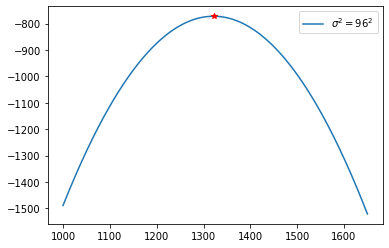

In [47]:
#Conhecendo a forma da função log-verossimilhança no exemplo da amostra da distribuição Normal
# 
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def get_ll_normal(x, mu, sigma):
    return np.sum(np.log(stats.norm.pdf(x, mu, sigma)))

x = data_reg.loc[data_reg['Sexo']==1,'Peso_Cerebral'] # Sexo Masculino   
print('Média da amostra: %.2f. Desvio Padrão da Amostra: %.2f' % (np.mean(x),np.std(x)) ) 


sigma = np.std(x) # # parâmetro fixo, igualado ao desvio padrão amostral
theta = np.linspace(1000, 1650, 1000) # parâmetro que vamos variar (mu)
f_theta1 = np.array([get_ll_normal(x, mu, sigma) for mu in theta])

i_best = np.argmax(f_theta1) # cálculo (numérico) do estimador de máxima verossimilhança (EMV) de mu
print('Melhor Média Estimada: %.2f' % theta[i_best])

plt.plot(theta, f_theta1, label = r'$\sigma^2=96^2$')
plt.plot([theta[i_best]], [f_theta1[i_best]], 'r*') # coloca uma estrelinha no maior valor (EMV)
plt.legend()

In [48]:
##-- Intervalo de confiança para a média 
import statsmodels.stats.api as sms

lim = sms.DescrStatsW(x).tconfint_mean() # IC para média de uma Normal (desvio padrão populacioanl desconhecido)
print ('IC ( %.2f ,  %.2f )'  % (lim[0],lim[1]))

IC ( 1304.57 ,  1338.31 )


#### Sexo Feminino

In [49]:
##-- Verificar normalidade para a variável Peso Cerebral com a finaldiade de estimar a média e o intervalo de confiança
## O teste de Shapiro-Wilk testa a hipótese nula de que os dados foram extraídos de uma distribuição normal
x = data_reg.loc[data_reg['Sexo']==0,'Peso_Cerebral'] # Sexo Feminino
stats.shapiro(x)

(0.9910722374916077, 0.7391230463981628)

> Podemos assumir a normalidade da amostra, pois o p-value (0,7391) superior a 5%.

Média da amostra: 1221.74. Desvio Padrão da Amostra: 100.45
Melhor Média Estimada: 1222.02


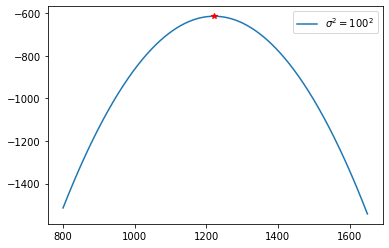

In [50]:
#Conhecendo a forma da função log-verossimilhança no exemplo da amostra da distribuição Normal
# 
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def get_ll_normal(x, mu, sigma):
    return np.sum(np.log(stats.norm.pdf(x, mu, sigma)))

x = data_reg.loc[data_reg['Sexo']==0,'Peso_Cerebral'] # Sexo Feminino   
print('Média da amostra: %.2f. Desvio Padrão da Amostra: %.2f' % (np.mean(x),np.std(x)) ) 


sigma = np.std(x) # # parâmetro fixo, igualado ao desvio padrão amostral
theta = np.linspace(800, 1650, 1000) # parâmetro que vamos variar (mu)
f_theta1 = np.array([get_ll_normal(x, mu, sigma) for mu in theta])

i_best = np.argmax(f_theta1) # cálculo (numérico) do estimador de máxima verossimilhança (EMV) de mu
print('Melhor Média Estimada: %.2f' % theta[i_best])

plt.plot(theta, f_theta1, label = r'$\sigma^2=100^2$')
plt.plot([theta[i_best]], [f_theta1[i_best]], 'r*') # coloca uma estrelinha no maior valor (EMV)
plt.legend()

In [51]:
##-- Intervalo de confiança para a média 
import statsmodels.stats.api as sms

lim = sms.DescrStatsW(x).tconfint_mean() # IC para média de uma Normal (desvio padrão populacioanl desconhecido)
print ('IC ( %.2f ,  %.2f )'  % (lim[0],lim[1]))

IC ( 1201.91 ,  1241.56 )


## Solução para estimar o peso médio do cérebro de homens e de mulheres (pontual e intervalar) através da estatística bayesiana

In [52]:
%matplotlib inline
import numpy as np
import theano.tensor as tt
import pymc3 as pm
import pymc3 

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context('notebook')
plt.style.use('seaborn-darkgrid')

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\romul\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


> Para estimar o peso médio do cérebro de homens e de mulheres através do método bayesiano, foi utilizado o método Máximo Probabilidade a Posteriori (MAP) e o Métodos de Monte Carlo via Cadeias de Markov (MCMC).

> De forma similar ao caso da máxima verossimilhança, o MAP é o valor de θ (parâmetro) que maximiza a função a posteriori.

> Por sua vez, a MCMC é um processo que transforma um problema com característica estática num problema de natureza dinâmica, construindo um processo estocástico temporal, que convirja, fracamente, para a distribuição original. Supõe-se que esse processo temporal é uma cadeia de Markov homogênea cuja distribuição de equilíbrio é a distribuição que será simulada. O algoritmo Metropolis-Hastings dá suporte a construção de cadeiras de Markov com distribuições de equilíbrio. A associação deste algoritmo com a simulação de distribuições pelo método de Monte Carlo busca resultados com aproximação de integrais. A finalidade é que os métodos possam ser utilizados de forma a simular distribuições a posteriori na resolução de problemas de inferência Bayesiana.

> Considerando o problema em questão, as médias do peso cerebral para homens e para mulheres foi recuperada através de pesquisa encontrada no site:
https://super.abril.com.br/historia/o-peso-do-cerebro/#:~:text=No%20s%C3%A9culo%2019%2Co%20fisiologista,era%20de%201%20250%20gramas. Acessado em 12/6/2020.

>Como nas informações da pesquisa não havia o desvio-padrão, e considerando que pelo teste de Levene feito no item 3.1.1 as variâncias dos pesos dos cérebros de homens e de mulheres podem ser consideradas iguais, apesar de suas médias serem consideradas diferentes (verificação feita através do t de Student no item 3.1.2), considerou-se no problema, a estimativa robusta do desvio padrão [ds = (Q3 - Q1)/ 1.34898] para a população para fazer a simulação da posteriori.


#### Sexo Masculino

In [58]:
##-- Estimativa do desvio padrão para a população, considerando o sexo masculino, considerando que há simetria na distribuição
var = data_reg.loc[data_reg['Sexo']==1,'Peso_Cerebral'] # Sexo Masculino 

Q1 = var.quantile(0.25)
Q3 = var.quantile(0.75)
  
ds = (Q3 - Q1)/ 1.34898
ds

103.78211685866357

Desvio Padrão amostral:  96.46334460484262


logp = -783.68, ||grad|| = 0.39591: 100%|███████████████████████████████████████████████| 5/5 [00:00<00:00, 358.13it/s]


{'mu': array(1321.63184618)}


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [mu]
Sampling chain 1, 0 divergences: 100%|████████████████████████████████████████████| 6000/6000 [00:34<00:00, 173.63it/s]


        mean     sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu  1321.742  8.475  1305.832  1337.376      0.127     0.09    4455.0  4455.0   

    ess_bulk  ess_tail  r_hat  
mu    4472.0    7132.0    1.0  


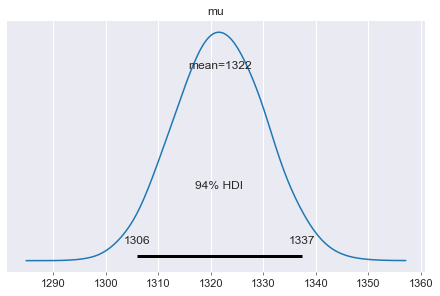

In [60]:
# Simula com o conjunto de dados Masculino
data = data_reg.loc[data_reg['Sexo']==1,'Peso_Cerebral'] # Sexo Masculino 
sigma =np.std(data) #  parâmetro fixo, igualado ao desvio padrão amostral
print ('Desvio Padrão amostral: ', sigma)

# Cria o modelo com a priori Normal com base nos dados observados e a partir da verossimilhança.
def creat_model_pymc3(data):
        with pymc3.Model() as model:
                mu = pm.Normal('mu', mu=1350, sigma=ds) #-- mu=dados pesquisa  sigma=estimativa do desvio padrao
                obs = pm.Normal('obs', mu=mu, sigma=sigma, observed=data) #-- dados obeservados
        return model
    
model = creat_model_pymc3(data)

# Estima a probabilidade de sucesso pela Normal por MAP
map_estimate = pymc3.find_MAP(model=model)
print(map_estimate)

# Usa MCMC para simular observações da posteriori (método de cálculo da posteriori por simulação)
# o primeiro valor (5000) especifica o número de observações que serão geradas da função a posteriori 
# para a obtenção do estimador bayesiano; tune=1000 representa o número de observações descartadas
# para melhorar a aproximação da posteriori
with model:
    trace = pymc3.sample(5000, tune=1000, cores=1)

# Resulta a média da posteriori (EAP), desvio padrão, intervalo de credibilidade HPD (intervalo e menos amplitude)....
summary=pymc3.summary(trace)
print(summary)

# Representa a posteriori, a média e o intervalo de credibilidade com menor amplitude, denotado por HPI (por simulação MCMC) 
pymc3.plot_posterior(trace);

  #### Sexo Feminino

In [61]:
##-- Estimativa do desvio padrão para a população, considerando o sexo masculino, considerando que há simetria na distribuição
var = data_reg.loc[data_reg['Sexo']==0,'Peso_Cerebral'] # Sexo Feminino 

Q1 = var.quantile(0.25)
Q3 = var.quantile(0.75)
  
ds = (Q3 - Q1)/ 1.34898
ds

101.92886477190173

Desvio Padrão amostral:  100.44849684804217


logp = -624.5, ||grad|| = 0.28573: 100%|████████████████████████████████████████████████| 5/5 [00:00<00:00, 499.81it/s]


{'mu': array(1222.00187031)}


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [mu]
Sampling chain 1, 0 divergences: 100%|████████████████████████████████████████████| 6000/6000 [00:26<00:00, 226.34it/s]


        mean     sd    hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu  1221.918  9.762  1203.304  1239.85      0.148    0.105    4322.0  4322.0   

    ess_bulk  ess_tail  r_hat  
mu    4319.0    6273.0    1.0  


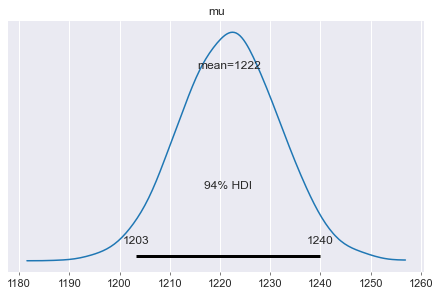

In [62]:
# Simula com o conjunto de dados Feminino
data = data_reg.loc[data_reg['Sexo']==0,'Peso_Cerebral'] # Sexo Feminino 
sigma =np.std(data) #  parâmetro fixo, igualado ao desvio padrão amostral
print ('Desvio Padrão amostral: ', sigma)

# Cria o modelo com a priori Normal com base nos dados observados e a partir da verossimilhança.
def creat_model_pymc3(data):
        with pymc3.Model() as model:
                mu = pm.Normal('mu', mu=1250, sigma=ds) #-- mu=dados pesquisa  sigma=estimativa do desvio padrao
                obs = pm.Normal('obs', mu=mu, sigma=sigma, observed=data) #-- dados obeservados
        return model
    
model = creat_model_pymc3(data)

# Estima a probabilidade de sucesso pela Normal por MAP
map_estimate = pymc3.find_MAP(model=model)
print(map_estimate)

# Usa MCMC para simular observações da posteriori (método de cálculo da posteriori por simulação)
# o primeiro valor (5000) especifica o número de observações que serão geradas da função a posteriori 
# para a obtenção do estimador bayesiano; tune=1000 representa o número de observações descartadas
# para melhorar a aproximação da posteriori
with model:
    trace = pymc3.sample(5000, tune=1000, cores=1)

# Resulta a média da posteriori (EAP), desvio padrão, intervalo de credibilidade HPD (intervalo e menos amplitude)....
summary=pymc3.summary(trace)
print(summary)

# Representa a posteriori, a média e o intervalo de credibilidade com menor amplitude, denotado por HPI (por simulação MCMC) 
pymc3.plot_posterior(trace);